### 필수 라이브러리 불러오기

In [1]:
import pandas as pd # 데이터 프레임을 사용하기 위한 라이브러리
from datetime import datetime # 년, 월, 일로 날짜를 표현할 때 사용하는 모듈
import numpy as np # 벡터 및 행렬연산을 하기 위한 라이브러리
import scipy as sp # 수치적분 루틴과 미분방정식 해석기, 방정식의 근을 구하는 알고리즘, 표준 연속/이산 확률분포와 다양한 통계관련 도구 등을 제공하는 라이브러리
import sklearn # python을 대표하는 머신러닝 라이브러리
import sys # 파이썬 인터프리터가 제공하는 변수와 함수를 직접 제어할 수 있게 해주는 모듈

# 자연어 처리 관련 라이브러리 및 모듈
from nltk.corpus import stopwords # 불용어 관련 모듈
import nltk # 언어 처리 기능을 제공하는 파이썬 라이브러리
from nltk.stem import WordNetLemmatizer, SnowballStemmer # 표제어 및 어간추출 관련 모듈
from nltk.stem.porter import * # 가장 유명한 Stemmer 인 1980년도에 Porter 씨가 제안한 Porter Stemmer 불러오는 모듈
from nltk import word_tokenize # 토큰화 관련 모듈

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer # CountVectorizer는 빈도로 벡터화 하는 모듈, TfidfTransformer는 카운터 벡터화 후 TF-IDF 벡터로 바꿔주는 모듈, TF-IDF vectorizer 는 문서를 tf-idf의 feature matrix로 변환하는 클래스
from sklearn.decomposition import LatentDirichletAllocation # LDA 토픽모델링 관련 모듈
from sklearn.decomposition import NMF  # 음수 미포함 행렬 분해 관련 모듈
from sklearn.preprocessing import normalize # 정규화 모듈
from scipy import linalg # 선형대수학 관련 모듈

import gensim # 자연어 처리 대표적인 라이브러리 
from gensim.utils import simple_preprocess # 전처리 관련 모듈
from gensim.parsing.preprocessing import STOPWORDS # 불용어 관련 모듈
from tqdm import tqdm

In [2]:
import pickle # 일반 텍스트를 파일로 저장할 때 쓰는 모듈
import string

### 데이터 불러오기

- 네이버 뉴스 데이터

In [3]:
df = pd.read_csv('네이버지도리뷰_아르떼뮤지엄결과.csv', encoding='cp949', index_col=0)
#df_p = pd.read_csv('naver_news_patientspread.csv')

In [4]:
df.head()

,place_name,user_name,review,url
0,아르떼뮤지엄 강릉,대구송풍기,강릉 아르떼뮤지엄 이로써 여수 제주 강릉 까지 대한민국 아르떼뮤지엄 방문끝 각지...,https://pcmap.place.naver.com/place/1090555407...
1,아르떼뮤지엄 강릉,Olive71,이런곳 좋아요^^ 움직이는 명화를보는건 더 리얼한 감동으로 다가와요.유리에 비친 ...,https://pcmap.place.naver.com/place/1090555407...
2,아르떼뮤지엄 강릉,ujo****,여러가지모양의 불빛 으로 화려한모습을 보고 물줄기 파도 꽃 그림 파노라마 등 아주볼...,https://pcmap.place.naver.com/place/1090555407...
3,아르떼뮤지엄 강릉,수실라,계속 보고 있으면 어지러워요ㅜㅜ 사진을 멋지게 찍을 수 있어서 사진맛집이에요 크고 ...,https://pcmap.place.naver.com/place/1090555407...
4,아르떼뮤지엄 강릉,ssohenn,"오후 5시쯤 방문했는데, 바글바글하지는 않고 적당했어요. 17000원은 좀 비싼감...",https://pcmap.place.naver.com/place/1090555407...


In [5]:
# 고유값 확인
df.place_name.unique()

array(['아르떼뮤지엄 강릉', '아르떼뮤지엄 여수', '아르떼뮤지엄 제주'], dtype=object)

In [6]:
# 결측치 확인
df.isnull().sum()

place_name      0
user_name       0
review        165
url             0
dtype: int64

In [7]:
df.rename(columns={'review':'text'}, inplace=True)

In [8]:
# 결측치 제거
df = df[df.text.notnull()]

### 데이터 전처리

In [9]:
def clean_text(text):
    text = re.sub('http[s]?://\S+', '', text) # http url 제거
    text = re.sub('\S*@\S*\s?', '', text) # 기자 emails 제거
    text = re.sub(r'\[.*?\]', '', text) # 대괄호안에 텍스트 제거 : 뉴스이름 + 기자이름
    text = re.sub(r'\w*\d\w*', '', text) # 숫자 포함하는 텍스트 제거
    text = re.sub('[?.,;:|\)*~`’!^\-_+<>@\#$%&-=#}※]', '', text)#특수문자 이모티콘 제거
    text = re.sub("\n", '', text) #개행문자 제거
    text = re.sub("\xa0", '', text) #개행문자 제거
    text = re.sub(r'Copyright .* rights reserved', '', text) # "Copyright all rights reserved" 제거
    return text

In [10]:
df['text_clean'] = pd.DataFrame(df.text.apply(lambda x: clean_text(x)))

In [11]:
df.head()

,place_name,user_name,text,url,text_clean
0,아르떼뮤지엄 강릉,대구송풍기,강릉 아르떼뮤지엄 이로써 여수 제주 강릉 까지 대한민국 아르떼뮤지엄 방문끝 각지...,https://pcmap.place.naver.com/place/1090555407...,강릉 아르떼뮤지엄 이로써 여수 제주 강릉 까지 대한민국 아르떼뮤지엄 방문끝 각지...
1,아르떼뮤지엄 강릉,Olive71,이런곳 좋아요^^ 움직이는 명화를보는건 더 리얼한 감동으로 다가와요.유리에 비친 ...,https://pcmap.place.naver.com/place/1090555407...,이런곳 좋아요 움직이는 명화를보는건 더 리얼한 감동으로 다가와요유리에 비친 조명그...
2,아르떼뮤지엄 강릉,ujo****,여러가지모양의 불빛 으로 화려한모습을 보고 물줄기 파도 꽃 그림 파노라마 등 아주볼...,https://pcmap.place.naver.com/place/1090555407...,여러가지모양의 불빛 으로 화려한모습을 보고 물줄기 파도 꽃 그림 파노라마 등 아주볼...
3,아르떼뮤지엄 강릉,수실라,계속 보고 있으면 어지러워요ㅜㅜ 사진을 멋지게 찍을 수 있어서 사진맛집이에요 크고 ...,https://pcmap.place.naver.com/place/1090555407...,계속 보고 있으면 어지러워요ㅜㅜ 사진을 멋지게 찍을 수 있어서 사진맛집이에요 크고 ...
4,아르떼뮤지엄 강릉,ssohenn,"오후 5시쯤 방문했는데, 바글바글하지는 않고 적당했어요. 17000원은 좀 비싼감...",https://pcmap.place.naver.com/place/1090555407...,오후 방문했는데 바글바글하지는 않고 적당했어요 좀 비싼감이 있지만 관광지에 핫...


### 형태소 분석

In [12]:
df = df[:100]

In [13]:
# KoNLPy는 한국어 정보처리를 위한 파이썬 패키지
# KoNLPy에는 총 5가지의 형태소 분석 방법을 제공하고 이는 Hannanum, Kkma, Komoran, Mecab, Okt(구 Twitter) 5가지 클래스로 제공

from konlpy.tag import Okt

In [14]:
# okt = Okt()
# texts_ko = [okt.morphs(doc) for doc in df.text_clean]
# print(texts_ko[0])

In [15]:
# # 명사 추출
# text_noun = [okt.nouns(doc) for doc in df.text_clean]
# print(text_noun[0])

### 불용어 제거

In [16]:
# 한국어 불용어 불러오기
import json
with open('korean_stopwords.json', encoding='utf-8') as f:
    stopwordss = json.load(f)

In [17]:
stopwordss[:10]

['!', '"', '$', '%', '&', "'", '(', ')', '*', '+']

In [18]:
# 불용어 추가
stopwordss.extend(['에서','고','이다','는','한','씨','하다'])

In [19]:
def preprocess_okt(text):
    #     text = spacing(text) # 띄어쓰기 보정 위에서 했으면 필요없습니다'
    okt=Okt()
    pos_words = okt.pos(text, stem=True)
    words = [word for word, tag in pos_words if tag in ['Noun', 'Adjective', 'Verb'] ]
    stopwords = stopwordss
    stopped_words = [w for w in words if not w in stopwords]
    return stopped_words

In [20]:
df['text_clean_okt'] = ""

In [21]:
for i in tqdm(range(len(df))):
    df.text_clean_okt.iloc[i] = preprocess_okt(df.text_clean.iloc[i])

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.28it/s]


In [22]:
df = df.reset_index(drop = True)
df.head()

,place_name,user_name,text,url,text_clean,text_clean_okt
0,아르떼뮤지엄 강릉,대구송풍기,강릉 아르떼뮤지엄 이로써 여수 제주 강릉 까지 대한민국 아르떼뮤지엄 방문끝 각지...,https://pcmap.place.naver.com/place/1090555407...,강릉 아르떼뮤지엄 이로써 여수 제주 강릉 까지 대한민국 아르떼뮤지엄 방문끝 각지...,"[강릉, 아르떼, 뮤, 지엄, 여수, 제주, 강릉, 대한민국, 아르떼, 뮤, 지엄,..."
1,아르떼뮤지엄 강릉,Olive71,이런곳 좋아요^^ 움직이는 명화를보는건 더 리얼한 감동으로 다가와요.유리에 비친 ...,https://pcmap.place.naver.com/place/1090555407...,이런곳 좋아요 움직이는 명화를보는건 더 리얼한 감동으로 다가와요유리에 비친 조명그...,"[곳, 좋다, 움직이다, 명화, 보다, 더, 리얼, 감동, 다가오다, 유리, 비치다..."
2,아르떼뮤지엄 강릉,ujo****,여러가지모양의 불빛 으로 화려한모습을 보고 물줄기 파도 꽃 그림 파노라마 등 아주볼...,https://pcmap.place.naver.com/place/1090555407...,여러가지모양의 불빛 으로 화려한모습을 보고 물줄기 파도 꽃 그림 파노라마 등 아주볼...,"[여러가지, 모양, 불빛, 화려하다, 모습, 보고, 물줄기, 파도, 꽃, 그림, 파..."
3,아르떼뮤지엄 강릉,수실라,계속 보고 있으면 어지러워요ㅜㅜ 사진을 멋지게 찍을 수 있어서 사진맛집이에요 크고 ...,https://pcmap.place.naver.com/place/1090555407...,계속 보고 있으면 어지러워요ㅜㅜ 사진을 멋지게 찍을 수 있어서 사진맛집이에요 크고 ...,"[계속, 보고, 어지럽다, 사진, 멋지다, 찍, 수, 사진, 맛집, 크다, 웅장, ..."
4,아르떼뮤지엄 강릉,ssohenn,"오후 5시쯤 방문했는데, 바글바글하지는 않고 적당했어요. 17000원은 좀 비싼감...",https://pcmap.place.naver.com/place/1090555407...,오후 방문했는데 바글바글하지는 않고 적당했어요 좀 비싼감이 있지만 관광지에 핫...,"[오후, 방문, 않다, 적당하다, 비싸다, 감, 관광지, 핫, 곳, 수, 없다, 남..."


In [23]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df["text_clean"])]
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

In [24]:
from gensim.test.utils import get_tmpfile
fname = get_tmpfile("my_doc2vec_model")
model.save(fname)
model = Doc2Vec.load(fname)  # you can continue training with the loaded mode

In [25]:
vector = model.infer_vector(["system", "response"])

In [26]:
document_vectors = []
for i in range(len(df)):
    document_vectors.append(model.docvecs[i])
document_vectors

C:\Users\mh\AppData\Local\Temp\ipykernel_27216\952498421.py:3: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  document_vectors.append(model.docvecs[i])


[array([-0.16208465,  0.3086441 , -0.80255127, -2.2092075 , -0.26295865],
       dtype=float32),
 array([-0.06178859,  0.24749534, -0.69559836, -2.7575061 , -0.30667284],
       dtype=float32),
 array([ 0.01180229,  0.35970968, -0.43962583, -1.7543546 , -0.27968743],
       dtype=float32),
 array([-0.25007504,  0.3608859 , -0.23919739, -2.1271274 , -0.33766276],
       dtype=float32),
 array([-0.10992968,  0.4137924 , -0.57938564, -2.12753   , -0.13251957],
       dtype=float32),
 array([-0.24659097,  0.0927195 , -0.46868858, -1.391764  , -0.39074245],
       dtype=float32),
 array([ 0.05430708,  0.42417443, -0.4879819 , -1.7472719 , -0.25468352],
       dtype=float32),
 array([-0.05891202,  0.26174065, -0.5545774 , -1.761898  , -0.17989922],
       dtype=float32),
 array([-0.1448992 ,  0.2092238 , -0.37874526, -2.3478575 , -0.22590663],
       dtype=float32),
 array([-0.12485354,  0.27423018, -0.42297405, -1.562509  , -0.40365097],
       dtype=float32),
 array([-0.1105755 ,  0.360181

In [27]:
#ward 에 필요한 라이브러리 import
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import silhouette_score

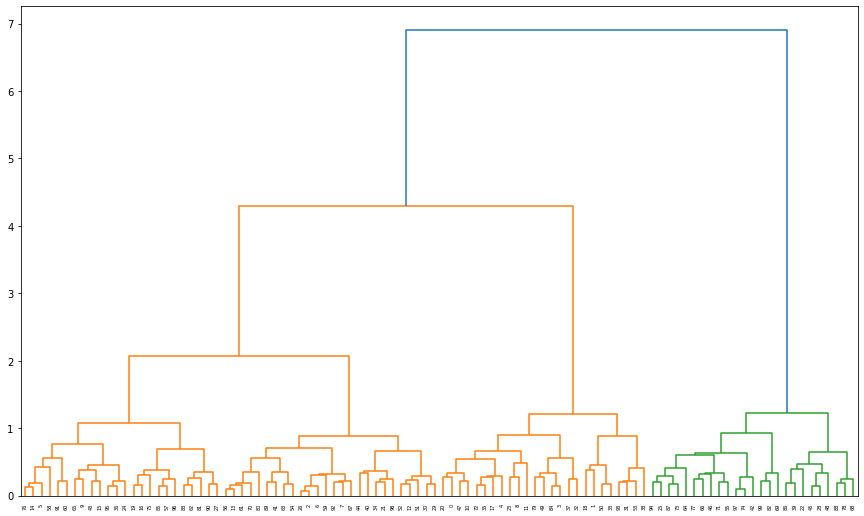

In [28]:
linked = linkage(document_vectors, 'ward') #document vector로 ward clustering진행 #시간 오래 걸림

plt.figure(figsize=(15, 9)) #그래프 사이즈 지정
#덴드로그램 그리기
dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

In [29]:
# 클러스터 6개로 만들기
cluster = AgglomerativeClustering(n_clusters=6, 
                                 linkage='ward')

result = cluster.fit_predict(document_vectors)

In [31]:
df['cluster'] = result
df.head()

,place_name,user_name,text,url,text_clean,text_clean_okt,cluster
0,아르떼뮤지엄 강릉,대구송풍기,강릉 아르떼뮤지엄 이로써 여수 제주 강릉 까지 대한민국 아르떼뮤지엄 방문끝 각지...,https://pcmap.place.naver.com/place/1090555407...,강릉 아르떼뮤지엄 이로써 여수 제주 강릉 까지 대한민국 아르떼뮤지엄 방문끝 각지...,"[강릉, 아르떼, 뮤, 지엄, 여수, 제주, 강릉, 대한민국, 아르떼, 뮤, 지엄,...",1
1,아르떼뮤지엄 강릉,Olive71,이런곳 좋아요^^ 움직이는 명화를보는건 더 리얼한 감동으로 다가와요.유리에 비친 ...,https://pcmap.place.naver.com/place/1090555407...,이런곳 좋아요 움직이는 명화를보는건 더 리얼한 감동으로 다가와요유리에 비친 조명그...,"[곳, 좋다, 움직이다, 명화, 보다, 더, 리얼, 감동, 다가오다, 유리, 비치다...",5
2,아르떼뮤지엄 강릉,ujo****,여러가지모양의 불빛 으로 화려한모습을 보고 물줄기 파도 꽃 그림 파노라마 등 아주볼...,https://pcmap.place.naver.com/place/1090555407...,여러가지모양의 불빛 으로 화려한모습을 보고 물줄기 파도 꽃 그림 파노라마 등 아주볼...,"[여러가지, 모양, 불빛, 화려하다, 모습, 보고, 물줄기, 파도, 꽃, 그림, 파...",3
3,아르떼뮤지엄 강릉,수실라,계속 보고 있으면 어지러워요ㅜㅜ 사진을 멋지게 찍을 수 있어서 사진맛집이에요 크고 ...,https://pcmap.place.naver.com/place/1090555407...,계속 보고 있으면 어지러워요ㅜㅜ 사진을 멋지게 찍을 수 있어서 사진맛집이에요 크고 ...,"[계속, 보고, 어지럽다, 사진, 멋지다, 찍, 수, 사진, 맛집, 크다, 웅장, ...",1
4,아르떼뮤지엄 강릉,ssohenn,"오후 5시쯤 방문했는데, 바글바글하지는 않고 적당했어요. 17000원은 좀 비싼감...",https://pcmap.place.naver.com/place/1090555407...,오후 방문했는데 바글바글하지는 않고 적당했어요 좀 비싼감이 있지만 관광지에 핫...,"[오후, 방문, 않다, 적당하다, 비싸다, 감, 관광지, 핫, 곳, 수, 없다, 남...",1
